In [6]:
"""
TODO: Implement optimization of "saturation" phase identification
* Use derivative to find "start" and initial guess for end
* Optimize ending cycle to maximize r^2 (and length?)
""";    

# Set up

In [7]:
import numpy as np
import pandas as pd
import matplotlib as mpl
# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib as pl
from scipy.stats import linregress

import bambi as bmb
import arviz as az

import candas as can
from candas.lims import Librarian, library, Fragment

SEED = 2022

In [8]:
code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

%config InlineBackend.figure_format = 'retina'

In [9]:
fig_num = 'S3'
# plt.style.use('style.mplstyle')

%config InlineBackend.figure_format = 'retina'

panel = None
subpanel = None

def savefig(fig=None, title=None):
    fig = fig or plt.gcf()
    title = title or 'Fig_'+'_'.join([str(el) for el in [fig_num, panel, subpanel] if el is not None])
    print(f'Saving {title} in {graph_pth}:', end='')
    for ext in ['svg', 'png']:
        try:
            fig.savefig(graph_pth / f'{title}.{ext}', dpi=600, transparent=True)
            print(f' [.{ext}]', end='')
        except AttributeError:
            print(f' [.{ext} failed]', end='')
    print(' done')

In [10]:
# cmax = 50

def get_experiment(pth):
    return pth.name.split(' ')[0]

def get_plate_map(pth):
    return pd.read_csv(pth).assign(Experiment = pth.name.split(' ')[0])

plate_maps = {pth.name.split(' ')[0]: get_plate_map(pth) for pth in data_pth.glob('*Plate Map.csv')}

def get_QS(pth):
    experiment = pth.name.split('_')[0]
    QS = (can.test.QuantStudio(pth, experiment)
            .import_data()
            .format_reactions()
            .index_reactions()
            .subtract_background(cycle_end=7)
            .get_derivatives(smoothing = 0.01)
            .annotate_reactions()
            # .trim_reactions()
            # .trim_reactions(max_c=90, threshold=0.005)
            # .normalize_reactions(cmax=cmax)  # , method='min-max')
            )
    
    QS.reactions.data = (
        QS.reactions.data
        [['Well','Outlier','Reaction','Cycle','Fluorescence','Derivative', 'Stage']]
        .merge(plate_maps[experiment], on='Well')
        # Well L17 is defective
        .query('WellName != "L17"')
        # The HEX_BHQ1 probe was mistakenly ordered with TET instead of HEX
        .replace({'Probe':{'HEX_BHQ1': 'TET_BHQ1'}})
        )
    
    return QS.reactions

reactions = {pth.name.split('_')[0]: get_QS(pth) for pth in data_pth.glob('*.xlsx')}

# Pre-processing

## Normalize the fluorescence values

In [11]:
data = pd.concat([reaction.data for reaction in reactions.values()], axis=0)

# Use the first cycle of the late phase to normalize the fluorescence and derivative

fnorm = (data
    .query('Stage == "late"')
    .sort_values('Cycle')
    .groupby(['Experiment','Well'])
    .first()
    .Fluorescence
)

## Extract the normalized drifts for each reaction

In [12]:
wide = pd.concat([reaction.wide for reaction in reactions.values()], axis=0)


In [13]:
grpd_data = data.query('Stage == "late"').groupby(
    ["Experiment", "Well"]
)

r2_threshold = 0.8

drifts = grpd_data.apply(lambda grp: linregress(grp.Cycle, grp.Fluorescence).slope)
r2s = grpd_data.apply(lambda grp: linregress(grp.Cycle, grp.Fluorescence).rvalue ** 2)
normdrifts = (
    np.log10(drifts / fnorm.loc[["JG076E", "JG076F"]])[r2s > r2_threshold]
    .rename("NormDrift")
    .reset_index()
)

# center and scale normdrifts
normdrifts["drift_z_score"] = (normdrifts["NormDrift"] - normdrifts["NormDrift"].mean()) / normdrifts["NormDrift"].std()

filtered_drifts = wide.query('Stage == "late"').merge(normdrifts).dropna()

# Pre-specify categorical orders to ensure logical comparison
# With this ordering, linear models will measure the relative effect of each factor versus 
# a FAM probe, with IBFQ quencher, and no intermediate

filtered_drifts.Fluorophore = filtered_drifts.Fluorophore.astype(
    "category"
).cat.reorder_categories(["FAM", "HEX", "TET", "SUN", "Cy3", "Cy5"], ordered=True)

filtered_drifts.Intermediate = filtered_drifts.Intermediate.astype(
    "category"
).cat.reorder_categories(["None", "Z", "T"], ordered=True)

filtered_drifts.Quencher = filtered_drifts.Quencher.astype(
    "category"
).cat.reorder_categories(["IBFQ", "BHQ1", "TAM", "IBRQ"], ordered=True)

drifts = (
    wide.query('Stage == "late"')
    .merge(normdrifts)
    .dropna(axis=0)
)


/home/john/projects/CAN_paper/env/can_manuscript/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
lib = Librarian().load(library).open()

bp_gc = lib.bp_gc_by(Fragment)


Saving Fig_S3_A in /home/john/projects/CAN_paper/fig_s3/graphics: [.svg] [.png] done


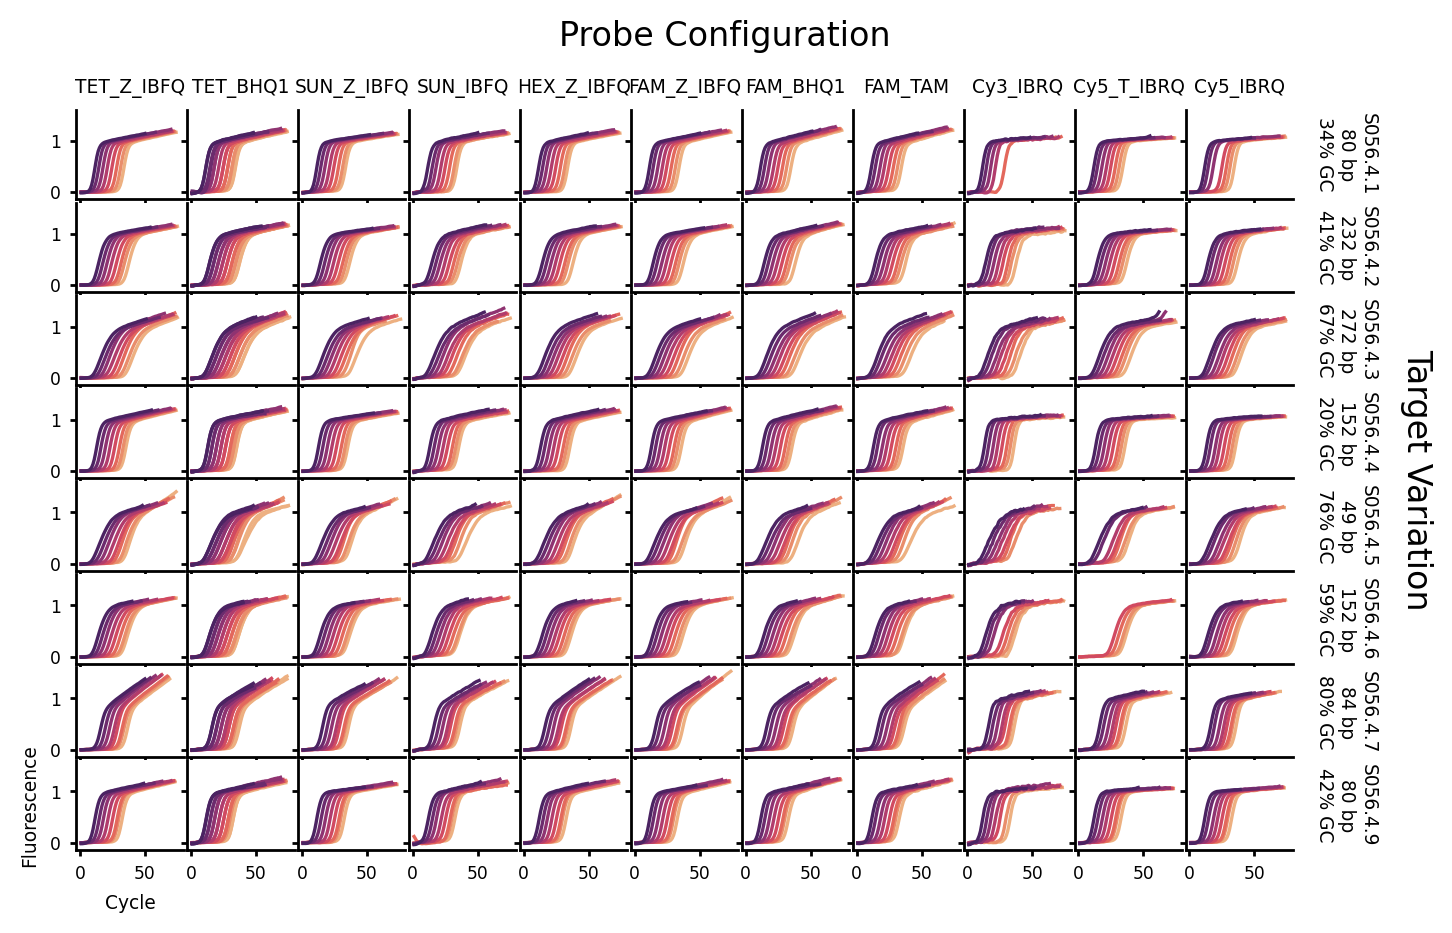

In [15]:
filtered_data = data.set_index(["Experiment", "Well"]).assign(Fluorescence = lambda df: df.Fluorescence/fnorm)
filtered_data = filtered_data[
    filtered_data.index.isin(filtered_drifts.set_index(["Experiment", "Well"]).index)
].reset_index()

figsize = width, height = (7.083, 4.6)
font_scale = 0.7

plt.close('all')


with sns.plotting_context('paper', font_scale = font_scale):

    g = sns.relplot(
        data=filtered_data.query('Stage != "secondary"'),
        x="Cycle",
        y="Fluorescence",
        kind="line",
        units="Reaction",
        estimator=None,
        row="Target",
        col="Probe",
        hue="lg10_Copies",
        palette="flare",
        facet_kws=dict(
            sharex=True,
            sharey=True,
            margin_titles=True
            ),
        legend=False,
    )
    
    g.set_titles(row_template = '', col_template = '{col_name}')

    g.fig.set_size_inches(figsize)


for (row_name, col_name), ax in g.axes_dict.items():
    ax.tick_params(axis='both', length=2)
    if ax is not g.axes[-1,0]:
        ax.set_xlabel('')
        ax.set_ylabel('')
    if ax in g.axes[:,-1]:
        row_target = f'{row_name}'
        row_bp = f'{bp_gc[bp_gc.Name==row_name].BP.iloc[0]} bp'
        row_gc = f'{bp_gc[bp_gc.Name==row_name].GC.iloc[0]:.0%} GC'
        row_label = '\n'.join([row_target, row_bp, row_gc])
        # ax.set_ylabel(row_label, rotation=-90, ha='left', va='center', fontsize=9.6*font_scale, y = 1.05)
        ax.annotate(
            row_label, xy=(1.5, .5), xycoords="axes fraction",
            rotation=270, ha="center", va="center", fontsize=9.6*font_scale
        )

mar_l = 0.3
mar_r = 0.7
mar_t = 0.45
mar_b = 0.45

plt.suptitle('Probe Configuration', fontsize=12, y=1.0, va='top')
g.fig.supylabel('Target Variation', fontsize=12, x=1.0, rotation=-90, va='center', ha='right')

plt.subplots_adjust(
    left=mar_l / width,
    right=1 - mar_r / width,
    top=1 - mar_t / height,
    bottom=mar_b / height,
)

panel = 'A'

savefig()

# Drift contributions

## Define a design matrix to specify all probe configurations

In [16]:
design_matrix = pd.concat([
    pd.get_dummies(filtered_drifts.Fluorophore),
    pd.get_dummies(filtered_drifts.Intermediate).drop(columns='None'),
    pd.get_dummies(filtered_drifts.Quencher)
], axis=1)

drift_matrix = pd.concat([
    filtered_drifts,
    design_matrix
], axis=1)


## Bayesian multiple linear regression

### Model specification

In [17]:
models = {}

models["f"] = bmb.Model(
    "drift_z_score ~ Fluorophore + Variation",
    filtered_drifts[
        ["drift_z_score", "Variation", "Intermediate", "Fluorophore", "Quencher"]
    ],
    categorical = ['Fluorophore', 'Variation']
)

models["fi"] = bmb.Model(
    "drift_z_score ~ Fluorophore + Intermediate + Variation",
    filtered_drifts[
        ["drift_z_score", "Variation", "Intermediate", "Fluorophore", "Quencher"]
    ],
    categorical = ['Fluorophore', 'Intermediate', 'Variation']
)

models["q"] = bmb.Model(
    "drift_z_score ~ Quencher + Variation",
    filtered_drifts[
        ["drift_z_score", "Variation", "Intermediate", "Fluorophore", "Quencher"]
    ],
    categorical = ['Quencher', 'Variation']
)

models["iq"] = bmb.Model(
    "drift_z_score ~ Quencher + Intermediate + Variation",
    filtered_drifts[
        ["drift_z_score", "Variation", "Intermediate", "Fluorophore", "Quencher"]
    ],
    categorical = ['Quencher', 'Variation', 'Intermediate']
)



low_wv_drifts = (filtered_drifts[
        ["drift_z_score", "Variation", "Intermediate", "Fluorophore", "Quencher"]
    ].query('Fluorophore in ["FAM","HEX","SUN","TET"]'))

low_wv_drifts.Fluorophore = filtered_drifts.Fluorophore.astype(
    "category"
).cat.set_categories(["FAM", "HEX", "TET", "SUN"], ordered=True)

low_wv_drifts.Intermediate = filtered_drifts.Intermediate.astype(
    "category"
).cat.set_categories(["None", "Z"], ordered=True)

low_wv_drifts.Quencher = filtered_drifts.Quencher.astype(
    "category"
).cat.set_categories(["IBFQ", "BHQ1", "TAM"], ordered=True)



models["fiq_low"] = bmb.Model(
    "drift_z_score ~ Fluorophore + Quencher + Intermediate + Variation", 
    low_wv_drifts,
    categorical = ['Fluorophore', 'Quencher', 'Variation', 'Intermediate']
)


### Model inferrence

In [18]:
idata = {}

for name, model in models.items():
    try:
        idata[name] = az.from_netcdf(gen_pth / f'hierarchical_drift_GLM_{name}.nc')
    except FileNotFoundError:
        idata[name] = model.fit(
            # tune=4000, 
            draws=4000, 
            # target_accept=0.9, 
            random_seed=SEED)
        idata[name].to_netcdf(gen_pth / f'hierarchical_drift_GLM_{name}.nc')

Saving Fig_S3_B in /home/john/projects/CAN_paper/fig_s3/graphics: [.svg] [.png] done
Saving Fig_S3_C in /home/john/projects/CAN_paper/fig_s3/graphics: [.svg] [.png] done


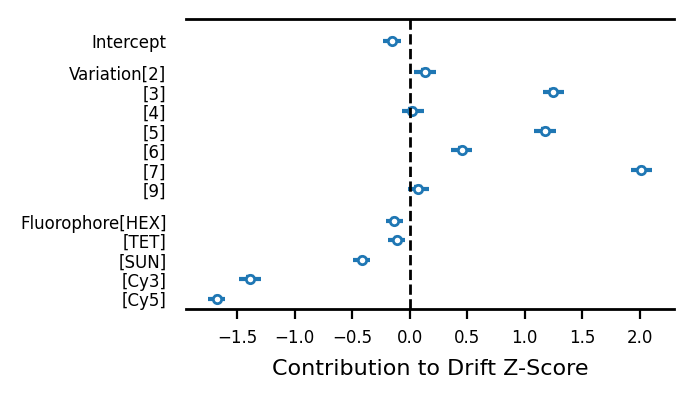

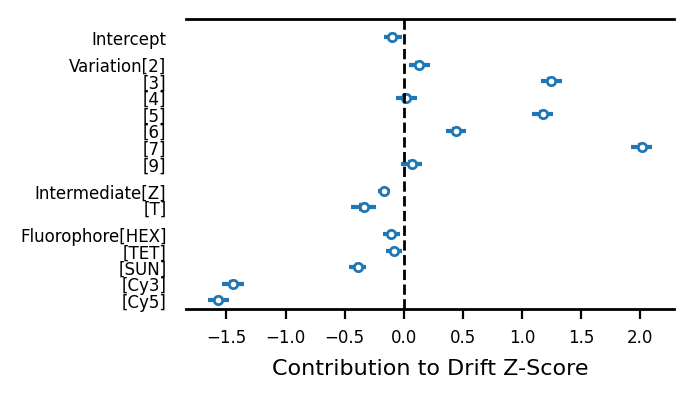

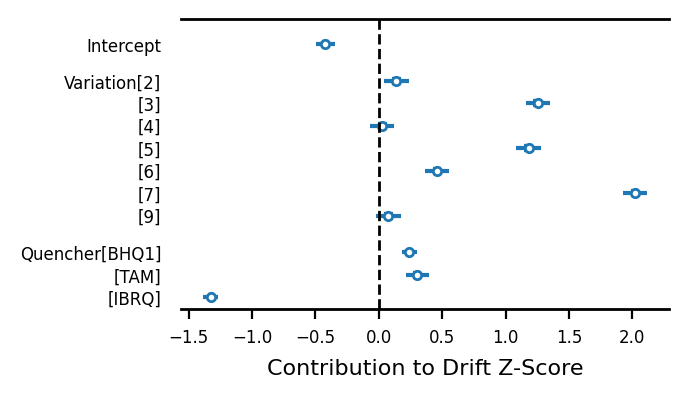

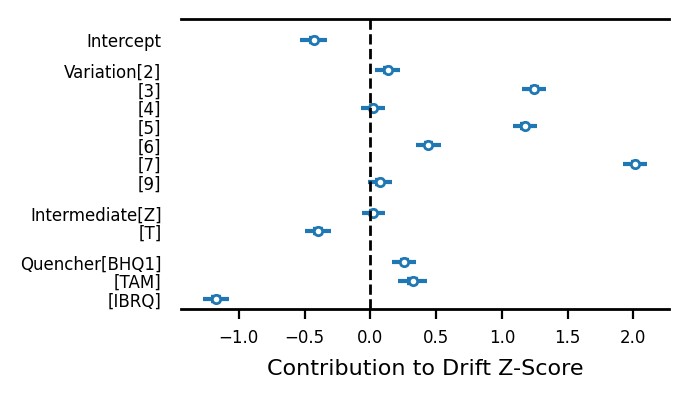

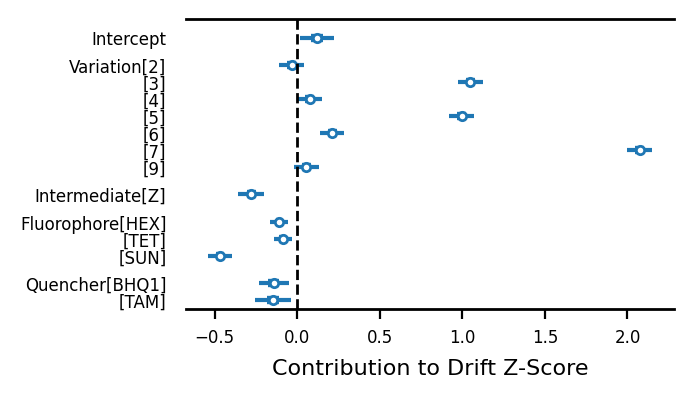

In [19]:
width = 7.083/2
height = 2
figsize = (width, height)
ticklabelsize = 10

mar_l = 0.8
mar_r = 0.3
mar_t = 0.05
mar_b = 0.5

model='f'

for model, data in idata.items():
    var_names = ['Intercept','Variation']
    if 'i' in model:
        var_names.append('Intermediate')
    if 'f' in model:
        var_names.append('Fluorophore')
    if 'q' in model:
        var_names.append('Quencher')

    az.plot_forest(idata[model], var_names=var_names, combined=True, figsize=figsize, markersize=4);
    plt.axvline(0, color='k', linestyle='--', linewidth=1)
    # plt.xtick_labels()
    ax = plt.gca()
    ax.set_xlabel('Contribution to Drift Z-Score', fontsize=8)
    ax.tick_params(axis='both', labelsize=6)
    ax.set_title('')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    plt.subplots_adjust(
        left=mar_l / width,
        right=1 - mar_r / width,
        top=1 - mar_t / height,
        bottom=mar_b / height,
    )
    
    panel = {'fi': 'B', 'iq': 'C'}
    
    if model in panel.keys():
        panel = panel[model]
        savefig()